# Particle Filter with Multivariate Normal Approximation 

**Jonathan Ramkissoon, Martin Lysy, University of Waterloo** 

---

## Introduction

Parameter inference for stochastic differential equations is challenging due to intractable likelihood functions that integrate over the entire latent space. Particle filters offer a principled solution by providing a consistent estimate of SDE log-likelihood. However, the multinomial resampling step traditionally used in particle filters is not smoothly differentiable with respect to SDE parameters, which can be problematic in many likelihood-based inference methods. In this work we propose a smoothly differentiable particle filter by replacing the resampling step with a multi- variate Normal approximation and utilizing the reparameterization trick. This enables a host of gradient based methods for parameter inference. This notebook explains the Multivariate Normal approximation within the particle filter and it's effect on parameter inference for stochastic differential equations. 

## Stochastic Differential Equations as State-Space Models

Let $\XX(t) = (X_1(t), \ldots, X_d(t))$ denote a $d$-dimensional process satisfying the stochastic differential equation (SDE)

$$
\ud \XX(t) = \dr_{\tth}(\XX(t)) \ud t + \df_{\tth}(\XX(t))^{1/2} \ud \BB(t),
$$

where $\dr_{\tth}(\XX)$ is a $d$-dimensional drift function and $\df_{\tth}(\XX)$ is a $d \times d$ positive-definite diffusion matrix.  We assume that $\XX(t)$ is measured with error at times $t_n = n \dt$ such that the observed data is $\YY_{0:N} = (\YY_0, \ldots, \YY_N)$ with

$$
\YY_n \ind g(\YY_n \mid \XX_n, \tth),
$$

where $\XX_n = \XX(t_n)$.  

Assume that the initial value of the SDE at time $t_0 = 0$ has the prior distribution $\XX_0 \sim \pi(\XX_0 \mid \tth)$. Then the likelihood function is given by

$$
\mathcal L(\tth \mid \YY_{0:N}) = \int \left[\pi(\XX_0 \mid \tth) \cdot \prod_{n=0}^N g(\YY_n \mid \XX_n, \tth) \cdot \prod_{n=1}^N p(\XX_n \mid \XX_{n-1}, \tth)\right] \ud \XX_{0:N}.
$$

However, this expression requires the SDE transition density $p(\XX_n \mid \XX_{n-1}, \tth)$, which is rarely available in closed form.  Instead, the likelihood function is approximated by the so-called Euler (or Euler-Maruyama) discretization method.  Namely, for $m \ge 1$ let $\XX\up m_n$ denote the value of the SDE at time $t = n \dt/m$, such that $\XX\up m_{mn} = \XX_n = \XX(t_n)$.  As $\dt_m = \dt/m \to 0$, the normal approximation

$$
\begin{aligned}
\XX\up m_n & \sim \N( \XX\up m_{n-1} + \dr_{\tth}(\XX\up m_{n-1}) \dt_m, \df_{\tth}(\XX\up m_{n-1}) \dt_m) \\
\iff \XX\up m_n & \sim \varphi(\XX\up m_n \mid \XX\up m_{n-1}, \tth)
\end{aligned}
$$

becomes increasingly accurate.  Thus the Euler approximation of order $m$ (or resolution $m$) to the likelihood function is

$$
\Lhat_m(\tth \mid \YY_{0:N}) = \int \left[\pi(\XX\up m_0 \mid \tth) \cdot \prod_{n=0}^N g(\YY_n \mid \XX\up m_{nm}, \tth) \cdot \prod_{n=1}^{Nm} \varphi(\XX\up m_n \mid \XX\up m_{n-1}, \tth)\right] \ud \XX\up m_{0:Nm},
$$

and we have $\Lhat_m(\tth \mid \YY_{0:N}) \to \mathcal L(\tth \mid \YY_{0:N})$ as $m \to \infty$.

## Log-Likelihood Estimation with Particle Filters

In general, a particle filter is initialized with a point cloud simulated from $\XX^* \sim p(X_0)$. At each timestep it is updated according to the transition density $p(X_t \mid X_{t-1}, \theta)$ and re-weighted according to $p(y_t \mid \XX^*_t, \theta)$. The resulting point cloud after this scheme are samples from the density $p(\XX_{t+1} \mid y_{t+1}, \theta)$. 

Under certain conditions, the bootstrap particle filter performs Multinomial resampling steps after re-weighting. **Why do we have the resampling step?**. After running this scheme for every timestep, we can sum the log-weights to get an estimate of the log-likelihood. 

In the context of gradient based inference methods, such as maximum likelihood, the multinomial resampling results in non-smooth estimates of the log-likelihood. To ensure a smooth estimate of the log-likelihood, the multinomial resampling step can be replaced with a Multivariate Normal distribution. 


- [x] SDE approximation to state-space model 
- [x] Particle filter estimation the log-likelihood
- [x] Multinomial approximation of particle distribution 
- [ ] Explanation of the model
- [ ] Explanation of the model in pfjax
- [ ] Comparison of MVN filter and bootstrap filter
    - [ ] Compare mode finding (i.e. stoch opt)
    - [ ] Stability of optimization 

# Lotka-Volterra Example

In [3]:
import time
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import jax
import jax.numpy as jnp
# import jax.scipy as jsp
import jax.random as random
# from jax import lax

import pfjax as pf
# import pfjax.sde

import warnings
warnings.filterwarnings('ignore')

In [4]:
# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.1 
tau_l = 0.1 

theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
theta_lims = np.array(list(zip(theta - (theta/5), theta + (theta/5))))

dt = 0.1
n_res = 1 
n_obs = 100
lotvol_model = pf.LotVolModel(dt, n_res) 

key = random.PRNGKey(0)
key, subkey = random.split(key)

x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(model = lotvol_model, 
                              n_obs = n_obs, 
                              x_init = x_init, 
                              theta = theta, 
                              key = subkey)

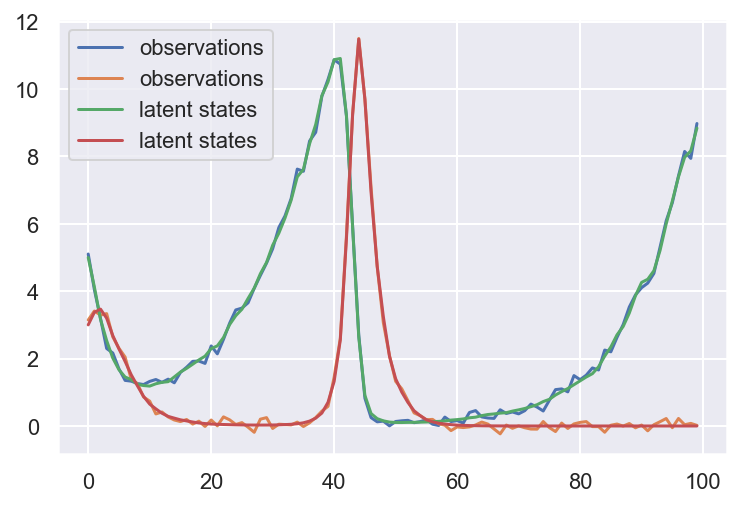

In [5]:
plt.plot(y_meas, label = "observations");
plt.plot(jnp.exp(x_state.squeeze()), label = "latent states")
plt.legend();

## Log-Likelihood Projection Plots

- [ ] Explain what this is: Bootstrap and MVN filter estimates of the log-likelihood for each parameter around the true value. 

In [27]:
# log-likelihood for Lotvol model with MVN resamplings
@jax.jit
def lotvol_pf_mvn_loglik(theta):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, 
                           y_meas=y_meas, 
                           n_particles=n_particles, key=key,
                           particle_sampler = pf.particle_resample_mvn)
    return pf.particle_loglik(temp['logw'])

# log-likelihood for Lotvol model with Multinomial resampling
@jax.jit
def lotvol_pf_loglik(theta):
    temp = pf.particle_filter(theta=theta, 
                           model=lotvol_model, y_meas=y_meas,
                           n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw'])

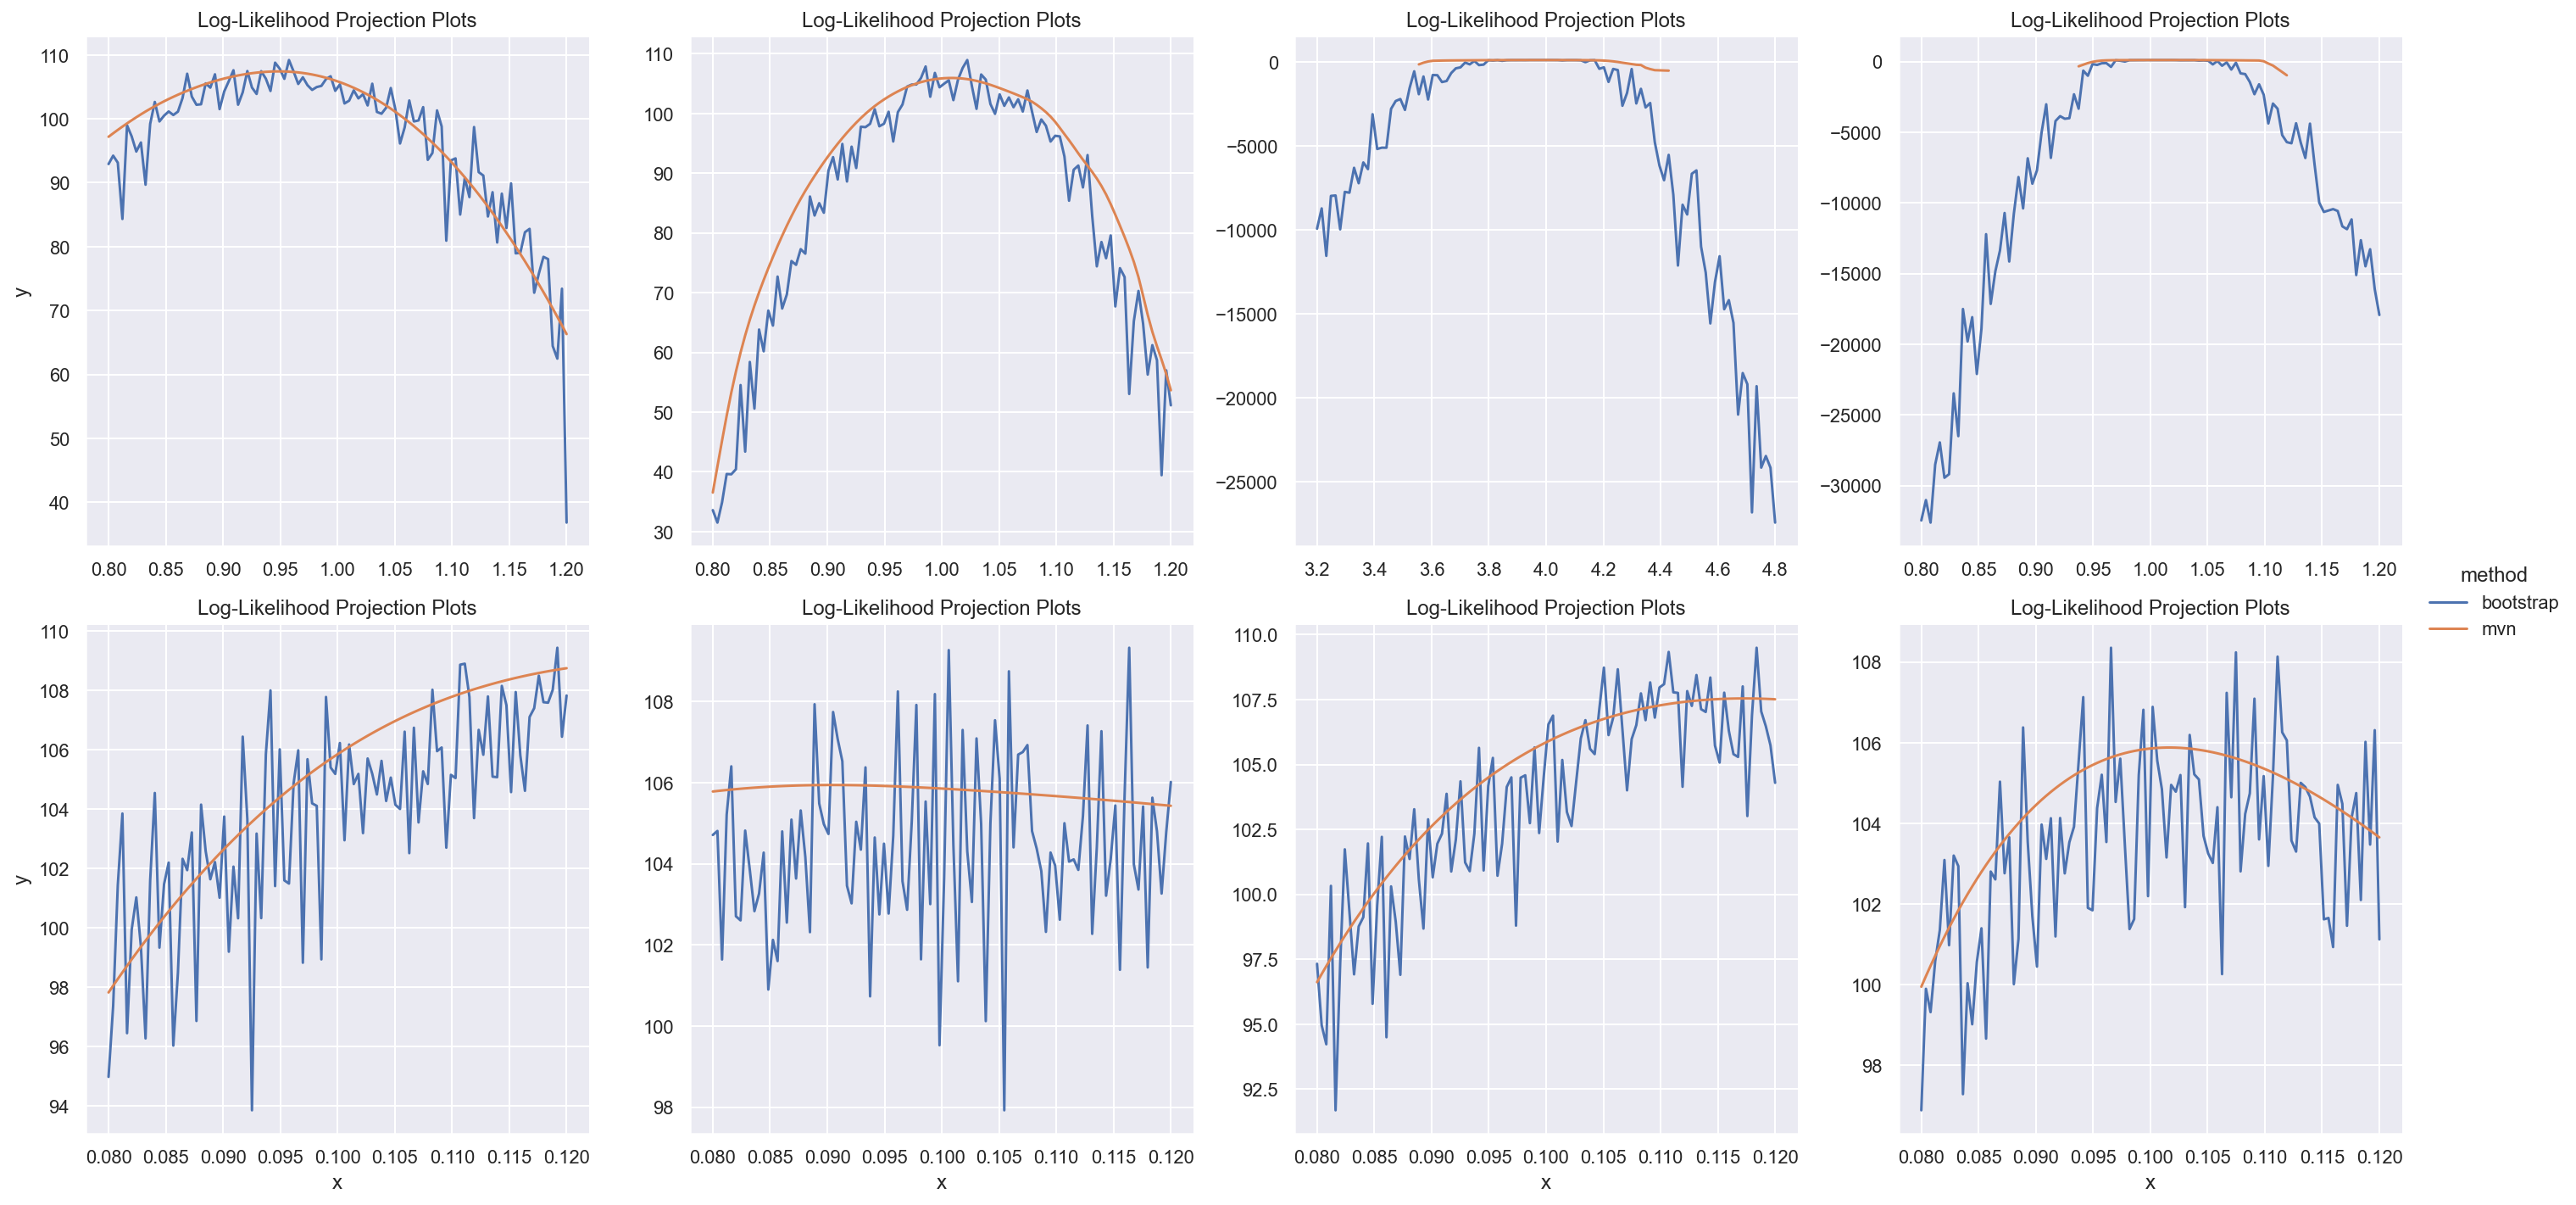

In [28]:
n_particles = 250

plot_mvn = pf.proj_data(fun = lambda x: lotvol_pf_mvn_loglik(x), 
                    theta = theta, theta_lims = theta_lims, 
                    theta_names = theta_names)

plot_bootstrap = pf.proj_data(fun = lambda x: lotvol_pf_loglik(x),
                           theta = theta, 
                           theta_lims = theta_lims, 
                           theta_names = theta_names)

plot_mvn["method"] = "mvn"
plot_bootstrap["method"] = "bootstrap"
df = pd.concat([plot_bootstrap, plot_mvn]).reset_index(drop=True)

sns.relplot(
    data=df, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title="Log-Likelihood Projection Plots");

## Full-Bayesian Inference

- [ ] Explain what we are doing here: Deterministic optimization of parameters. Use Fisher information matrix as the variance estimate.

In [29]:
import optax
from functools import partial

def simple_grad_descent (model, theta, grad_fun, y_meas, n_particles=100, 
                         n_iter=10, learning_rate=0.01, key=1, mask=None):
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(theta)
    partial_update_params = partial(pf.update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, 
                                    grad_fun=grad_fun, optimizer=optimizer)
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    for i in range(n_iter):
        # get value of loss function to make sure we are minimizing 
        theta = update_fn(theta, subkey, opt_state)
    return theta

In [33]:
init_params = jnp.array([1.,0.9, 3.8, 1., 0.1, 0.1, 0.1, 0.1])
print("True params: ", theta)
mvn_params = simple_grad_descent(
    key = key,
    model = lotvol_model,
    grad_fun = pf.particle_neg_loglik_mvn,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = 1e-2,
    n_iter = 50,
    n_particles = 100,
    mask=np.ones(len(init_params))
)
mvn_params

True params:  [1.  1.  4.  1.  0.1 0.1 0.1 0.1]
[1.  0.9 3.8 1.  0.1 0.1 0.1 0.1]
[0.99000007 0.9099999  3.81       0.99000007 0.10999993 0.10999993
 0.10999993 0.09000007]
[0.98000014 0.91999984 3.82       0.98000014 0.11999986 0.11999986
 0.11999986 0.1       ]
[0.9700002  0.92999977 3.83       0.99000007 0.1299998  0.10999993
 0.1299998  0.10999993]
[0.9600003  0.9399997  3.84       0.98000014 0.11999987 0.11999986
 0.13999973 0.1       ]
[0.95000035 0.94999963 3.85       0.99000007 0.1299998  0.10999993
 0.1299998  0.10999993]
[0.9400004  0.95999956 3.86       0.98000014 0.11999987 0.1
 0.11999987 0.1       ]
[0.9300005  0.9699995  3.87       0.99000007 0.1299998  0.09000007
 0.1299998  0.10999993]
[0.92000055 0.9799994  3.8799999  0.98000014 0.11999987 0.1
 0.11999987 0.1       ]
[0.9300005  0.9699995  3.8899999  0.99000007 0.1299998  0.09000007
 0.1299998  0.10999993]
[0.92000055 0.9799994  3.8999999  1.         0.13999973 0.10000001
 0.11999987 0.1       ]
[0.9100006  0.98999935

DeviceArray([0.92000055, 0.9799994 , 3.8999999 , 1.        , 0.13999973,
             0.10000001, 0.11999987, 0.1       ], dtype=float32)

In [34]:
# check that we have minimized the negative log-lik: Hessian should be positive definite: 
hessian_fn = jax.jacfwd(jax.jacrev(pf.particle_neg_loglik_mvn))
hess = hessian_fn(
    mvn_params,
    key,
    n_particles=100,
    y_meas=y_meas,
    model=lotvol_model)
print("Is positive definite?: ", jnp.all(jnp.linalg.eigvals(hess) >= 0))

Is positive definite?:  True


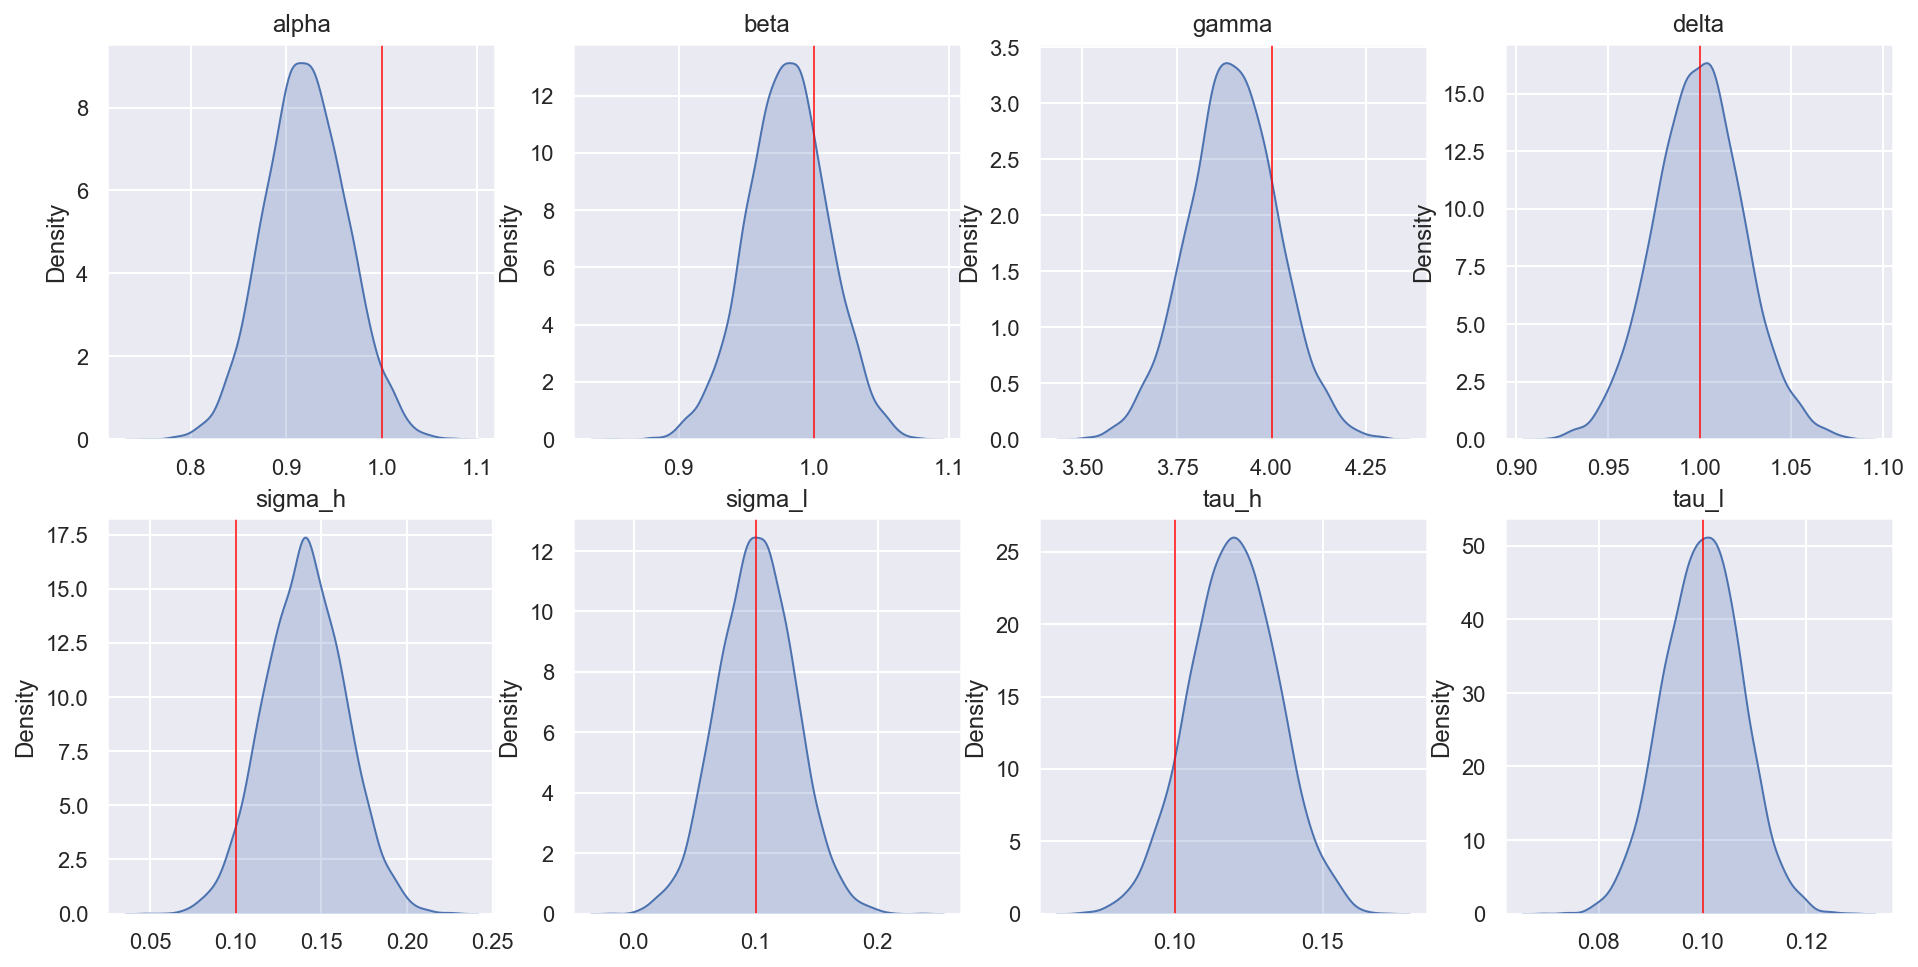

In [35]:
# Once hessian is positive definite, we can find the posterior variance. Otherwise continue optimization 
# posterior variance is the inverse negative hessian of the log-likelihood (Fisher Information)
var = jnp.linalg.inv(hess)

mle_samples = random.multivariate_normal(key=key, mean=mvn_params, cov=var, shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show();